L'obiettivo di questa esercitazione è quello di arrivare ad implementare un sistema completo di classificazione dei sopravvissuti al disastro del Titanic. Per farlo, partiremo dall'omonimo dataset, faremo un'analisi completa dello stesso, e cercheremo di raggiungere il miglior risultato possibile in termini di accuracy.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import VarianceThreshold

In [2]:
data = fetch_openml("titanic", version=1, as_frame=True)
df = data.frame

## Parte 1: Exploratory data analysis

Partiamo effettuando un'analisi esplorativa dei dati a nostra disposizione. Per prima cosa, visualizziamo i primi cinque dati, e rendiamoci conto di che tipo di feature stiamo parlando.

In [3]:
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1.0,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1.0,1,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1.0,0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"
3,1.0,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON"
4,1.0,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON"


Notiamo anche che ci sono dei NaN relativi alla cabia. Abbiamo due possibilità: la prima è quella di eliminare i dati, la seconda è quella di eliminare la feature. In particolar,e la conoscenza della cabina potrebbe essere utile per comprendere delle dinamiche di come si sono andati disponendo i passeggeri per essere salvati; tuttavia, non abbiamo a disposizione la mappa del titanic, per cui scelgiamo di elimniare l'intera feature. Infine, rimuoviamo anche il numero di ticket, in quanto non necessario alla nostra analisi.

In [4]:
df.drop(['name', 'ticket', 'cabin', 'body', 'home.dest'], axis=1, inplace=True)
df['boat'] = df['boat'].apply(lambda x: '0' if x is None else x)
df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked,boat
0,1.0,1,female,29.0000,0.0,0.0,211.3375,S,2
1,1.0,1,male,0.9167,1.0,2.0,151.5500,S,11
2,1.0,0,female,2.0000,1.0,2.0,151.5500,S,0
3,1.0,0,male,30.0000,1.0,2.0,151.5500,S,0
4,1.0,0,female,25.0000,1.0,2.0,151.5500,S,0


Rimaniamo con otto feature. Vediamo un attimo quali possono essere quelle più significative.

Survived rappresenta i passeggeri sopravvissuti, per cui la tratteremo come se fossero le label.

Analizziamo adesso brevemente l'istogramma di alcune altre feature. I particolare, ci interessa quello relativo all'etè ed al prezzo pagato per il biglietto.

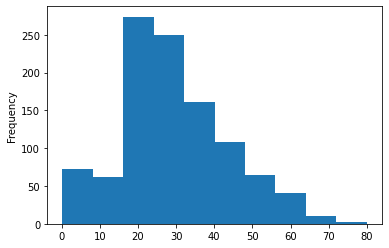

In [5]:
df['age'].plot.hist()
plt.show()

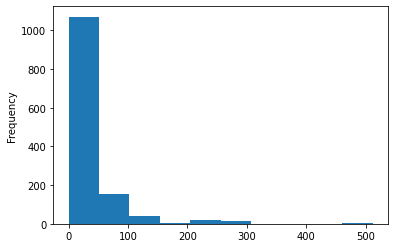

In [6]:
df['fare'].plot.hist()
plt.show()

Notiamo come la variabilità dell'età è sufficiente, mentre quella del ticket è bassa. Proveremo in tal senso ad usare una tecnica di feature selection basata su `VarianceThreshold`.

In ultimo, valutiamo la matrice di correlazione. Usiamo l'indice di correlazione di Kendall, che risulta essere maggiormente robusto rispetto a quello di Pearson ed a quello di Spearman. Per approfondire, ecco un [eccellente punto di partenza](https://datascience.stackexchange.com/a/64261) su Stack Exchange.

In [7]:
df.corr(method='kendall')

,pclass,age,sibsp,parch,fare
pclass,1.000000,-0.312672,-0.061628,-0.026480,-0.591579
age,-0.312672,1.000000,-0.100050,-0.171702,0.131694
sibsp,-0.061628,-0.100050,1.000000,0.415068,0.356791
parch,-0.026480,-0.171702,0.415068,1.000000,0.322767
fare,-0.591579,0.131694,0.356791,0.322767,1.000000


E' facile vedere come i risultati ci conducano alla conclusione che non vi sono feature fortemente correlate od anticorrelate; la correlazione maggiore che è possibile riscontrare è infatti tra classe del passeggero e tariffa (ed è negativa, come prevedibile: ciò significa che passeggeri con classe numerica più alta, ovvero terza, hanno pagato meno rispetto a passeggeri con classe numerica più bassa, ovvero seconda e prima).

## Parte 2: feature selection ed addestramento

Procediamo adesso alla feature selection ed all'addestramento. Useremo due algoritmi: il primo è un classificatore basato su alberi decisionali, mentre il secondo è un classificatore basato su MLP, ovvero su un'architettura di rete che è alla base delle reti neurali.

In [8]:
df.dropna(axis=0, inplace=True)
labels = df['survived']
df.drop('survived', axis=1, inplace=True)

In [21]:
ct = ColumnTransformer(
    [('sex_tr', OneHotEncoder(handle_unknown='ignore'), ['sex']),
     ('embarked_tr', OneHotEncoder(handle_unknown='ignore'), ['embarked']),
     ('boat_tr', OneHotEncoder(handle_unknown='ignore'), ['boat'])], remainder='passthrough')

In [10]:
X, y = ct.fit_transform(df), labels

In [11]:
dt = DecisionTreeClassifier()
mlp = MLPClassifier(max_iter=1000)

In [12]:
scoring=['accuracy']
dt_scores = cross_validate(dt, X, y, cv=10, scoring=scoring)
mlp_scores = cross_validate(mlp, X, y, cv=10, scoring=scoring)

In [13]:
mlp_scores['test_accuracy']

array([0.96190476, 0.98095238, 0.99047619, 0.98076923, 0.95192308,
       0.97115385, 0.97115385, 0.96153846, 0.96153846, 0.95192308])

In [14]:
dt_scores['test_accuracy']

array([0.97142857, 0.98095238, 0.95238095, 0.96153846, 0.95192308,
       0.96153846, 0.92307692, 0.95192308, 0.94230769, 0.95192308])

In [15]:
dt.fit(X, y)

DecisionTreeClassifier()

In [16]:
mlp.fit(X, y)

MLPClassifier(max_iter=1000)

## Parte 4: Utilizzo di una pipeline

In [22]:
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ('ct', ct),
    ('fs', VarianceThreshold()),
    ('clf', DecisionTreeClassifier()),
])

cross_validate(pipe, df, labels, cv=10)

{'fit_time': array([0.02409935, 0.01921844, 0.01503372, 0.01658511, 0.01601315,
        0.01597762, 0.01497436, 0.01499939, 0.0150001 , 0.01602507]),
 'score_time': array([0.01090026, 0.00911188, 0.00896788, 0.00908756, 0.00802398,
        0.00802159, 0.00802922, 0.00799942, 0.00700688, 0.00796485]),
 'test_score': array([0.96190476, 0.98095238, 0.95238095, 0.96153846, 0.94230769,
        0.96153846, 0.92307692, 0.94230769, 0.95192308, 0.95192308])}